In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, 
                           roc_curve, auc, precision_recall_curve, 
                           average_precision_score)
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load best model and test data
print("Loading best model and test data...")
best_model = joblib.load('../models/best_model.pkl')
scaler = joblib.load('../models/scaler.pkl')

final_data = pd.read_csv('../datasets/heart_failure_final_features.csv')
X = final_data.drop(columns=['hadm_id', 'readmission_30'])
y = final_data['readmission_30']

# Train-test split (same as before)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale test data
X_test_scaled = scaler.transform(X_test)


Loading best model and test data...


Predictions generated successfully.

=== COMPREHENSIVE MODEL EVALUATION ===


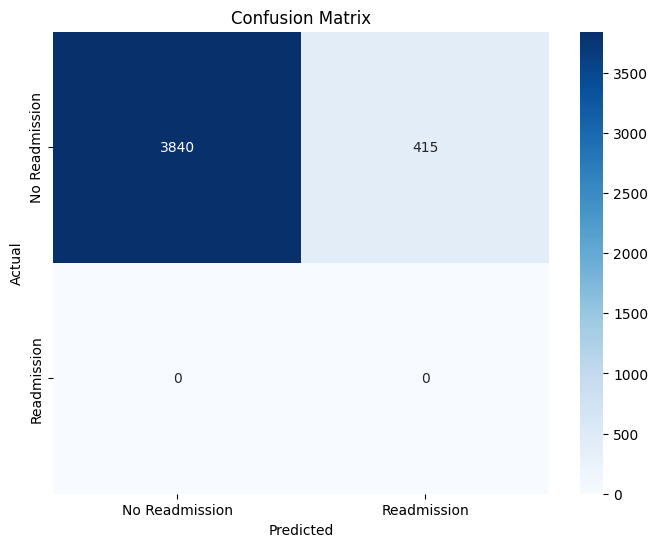


Classification Report:
                precision    recall  f1-score   support

No Readmission       1.00      0.90      0.95      4255
   Readmission       0.00      0.00      0.00         0

      accuracy                           0.90      4255
     macro avg       0.50      0.45      0.47      4255
  weighted avg       1.00      0.90      0.95      4255



In [3]:
# Predictions
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

print("Predictions generated successfully.")

# Comprehensive Model Evaluation
print("\n=== COMPREHENSIVE MODEL EVALUATION ===")

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Readmission', 'Readmission'],
            yticklabels=['No Readmission', 'Readmission'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 2. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=['No Readmission', 'Readmission']))

# 3. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

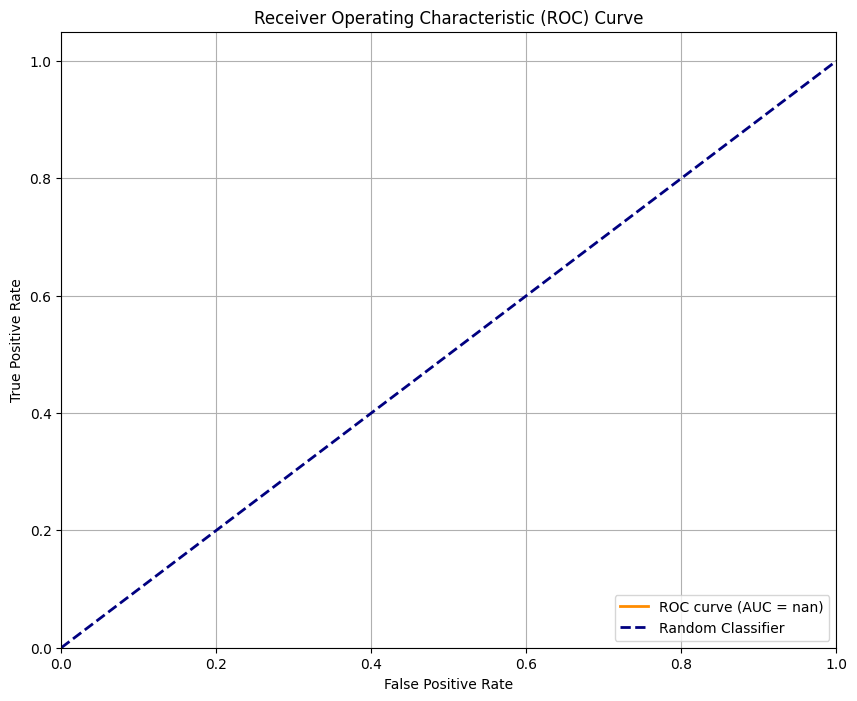

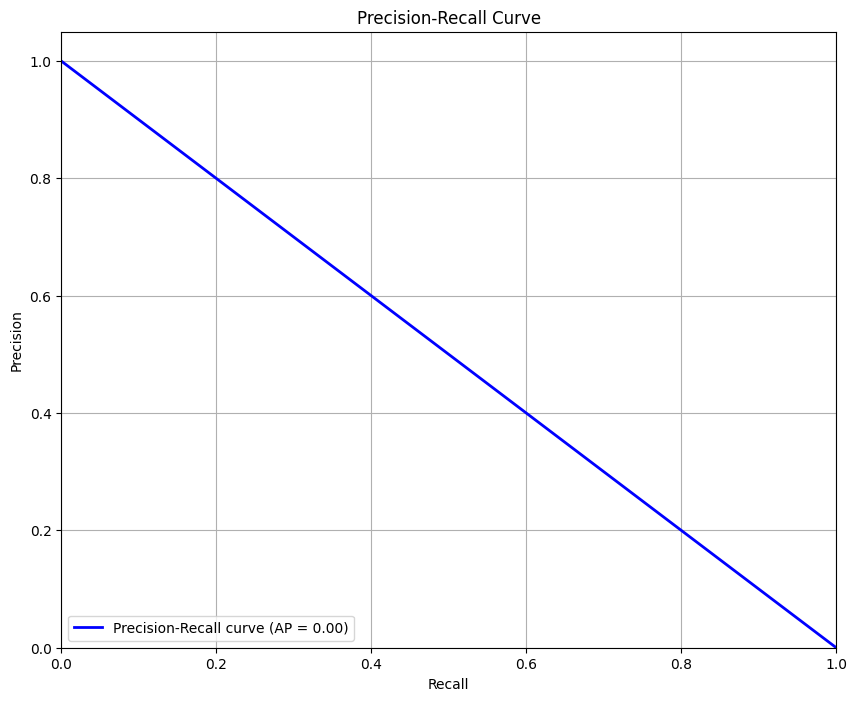

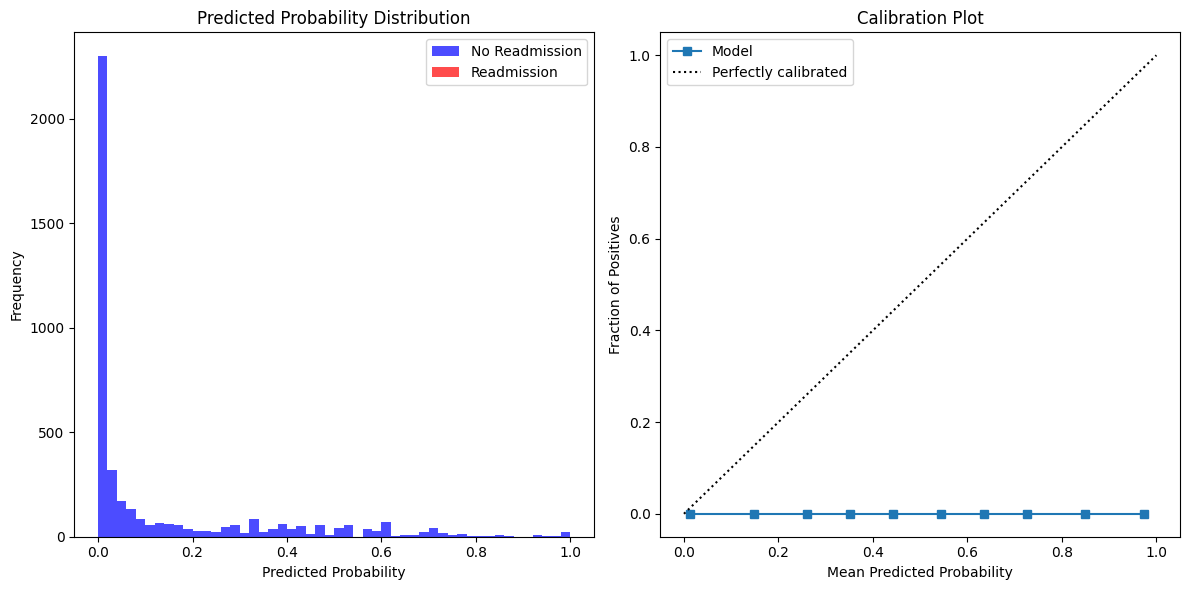

In [4]:
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 4. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2, 
         label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# 5. Probability Distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.7, label='No Readmission', color='blue')
plt.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.7, label='Readmission', color='red')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Predicted Probability Distribution')
plt.legend()

plt.subplot(1, 2, 2)
# Calibration plot
from sklearn.calibration import calibration_curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred_proba, n_bins=10)

plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot')
plt.legend()

plt.tight_layout()
plt.show()

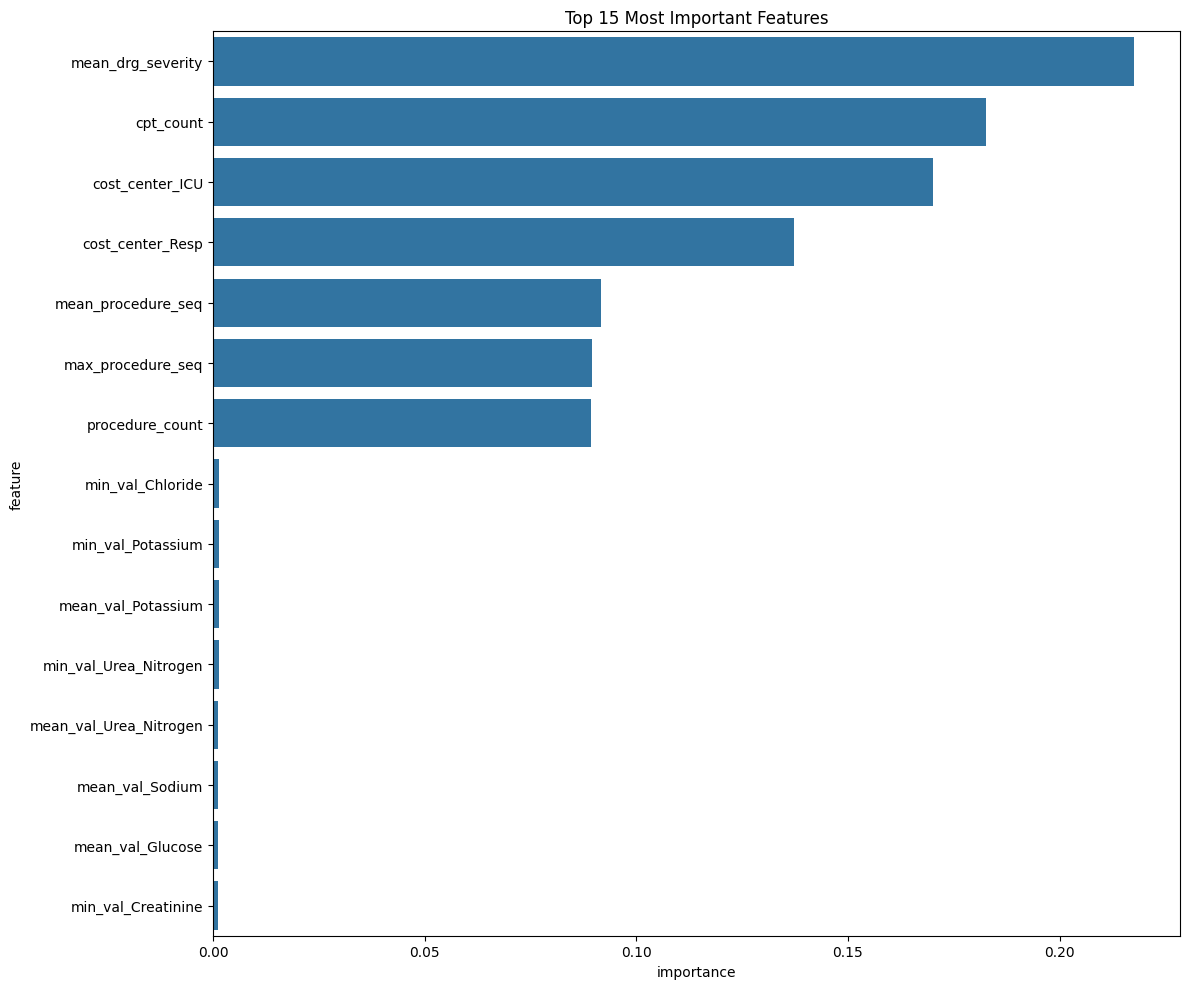


Top 10 Most Important Features:
               feature  importance
49   mean_drg_severity    0.217558
46           cpt_count    0.182513
47     cost_center_ICU    0.170193
48    cost_center_Resp    0.137267
45  mean_procedure_seq    0.091553
44   max_procedure_seq    0.089437
43     procedure_count    0.089312
15    min_val_Chloride    0.001477
23   min_val_Potassium    0.001473
8   mean_val_Potassium    0.001411

=== PERFORMANCE BY SUBGROUPS ===


NameError: name 'roc_auc_score' is not defined

In [5]:
# 6. Feature Importance Analysis (if available)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 10))
    top_features = feature_importance.head(15)
    sns.barplot(data=top_features, y='feature', x='importance')
    plt.title('Top 15 Most Important Features')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print(top_features.head(10))

# 7. Performance by Subgroups
print("\n=== PERFORMANCE BY SUBGROUPS ===")

# Load original data for subgroup analysis
original_data = pd.read_csv('../datasets/heart_failure_cleaned.csv')
test_indices = X_test.index
test_data_original = original_data.iloc[test_indices].copy()
test_data_original['predicted_prob'] = y_pred_proba
test_data_original['predicted_class'] = y_pred

# Age groups performance
test_data_original['age_group'] = test_data_original['age'].apply(
    lambda x: 'Young(<45)' if x < 45 else 'Middle(45-65)' if x < 65 else 'Senior(65-80)' if x < 80 else 'Elderly(80+)'
)

# Gender performance
gender_performance = test_data_original.groupby('gender').apply(
    lambda x: pd.Series({
        'roc_auc': roc_auc_score(x['readmission_30'], x['predicted_prob']),
        'precision': precision_score(x['readmission_30'], x['predicted_class']),
        'recall': recall_score(x['readmission_30'], x['predicted_class']),
        'f1': f1_score(x['readmission_30'], x['predicted_class']),
        'count': len(x)
    })
).round(4)


In [6]:
print("\nPerformance by Gender:")
print(gender_performance)

# Age group performance
age_performance = test_data_original.groupby('age_group').apply(
    lambda x: pd.Series({
        'roc_auc': roc_auc_score(x['readmission_30'], x['predicted_prob']),
        'precision': precision_score(x['readmission_30'], x['predicted_class']),
        'recall': recall_score(x['readmission_30'], x['predicted_class']),
        'f1': f1_score(x['readmission_30'], x['predicted_class']),
        'count': len(x)
    })
).round(4)

print("\nPerformance by Age Group:")
print(age_performance)

# 8. Business Impact Analysis
print("\n=== BUSINESS IMPACT ANALYSIS ===")

# Calculate cost savings
def calculate_cost_savings(y_true, y_pred, y_pred_proba, cost_per_readmission=15000, intervention_cost=1000):
    """
    Calculate potential cost savings from early intervention
    """
    # Current situation (no model)
    current_readmissions = y_true.sum()
    current_cost = current_readmissions * cost_per_readmission
    
    # With model intervention (intervene on top 20% high-risk patients)
    intervention_threshold = np.percentile(y_pred_proba, 80)
    intervene_mask = y_pred_proba >= intervention_threshold
    
    # Readmissions prevented (assuming 50% effectiveness)
    preventable_readmissions = (y_true & intervene_mask).sum()
    prevented_readmissions = preventable_readmissions * 0.5  # 50% effectiveness
    
    # Costs with intervention
    intervention_patients = intervene_mask.sum()
    intervention_costs = intervention_patients * intervention_cost
    remaining_readmissions = current_readmissions - prevented_readmissions
    readmission_costs = remaining_readmissions * cost_per_readmission
    total_cost_with_model = intervention_costs + readmission_costs
    
    # Cost savings
    cost_savings = current_cost - total_cost_with_model
    
    return {
        'current_cost': current_cost,
        'total_cost_with_model': total_cost_with_model,
        'cost_savings': cost_savings,
        'prevented_readmissions': prevented_readmissions,
        'intervention_patients': intervention_patients,
        'ROI': cost_savings / intervention_costs if intervention_costs > 0 else 0
    }

cost_analysis = calculate_cost_savings(y_test, y_pred, y_pred_proba)



Performance by Gender:


NameError: name 'gender_performance' is not defined

In [7]:
print("Business Impact Analysis:")
for key, value in cost_analysis.items():
    if key in ['current_cost', 'total_cost_with_model', 'cost_savings']:
        print(f"{key}: ${value:,.2f}")
    elif key == 'ROI':
        print(f"{key}: {value:.2f}x")
    else:
        print(f"{key}: {value}")

# 9. Model Deployment Preparation
print("\n=== MODEL DEPLOYMENT SUMMARY ===")

final_metrics = {
    'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    'Average Precision': average_precision_score(y_test, y_pred_proba),
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred)
}

print("\nFinal Model Performance Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")

# Save evaluation results
evaluation_results = {
    'final_metrics': final_metrics,
    'cost_analysis': cost_analysis,
    'subgroup_analysis': {
        'gender': gender_performance,
        'age': age_performance
    }
}

import json
with open('../models/evaluation_results.json', 'w') as f:
    json.dump(evaluation_results, f, indent=2)

print("\nEvaluation results saved successfully.")
print("\n=== PROJECT COMPLETED SUCCESSFULLY ===")

Business Impact Analysis:


NameError: name 'cost_analysis' is not defined